In [2]:
!pip install kornia
!pip install git+https://github.com/openai/CLIP.git

import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
from google.colab import drive
import os
import csv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cpu':
    raise RuntimeError("This code requires a GPU for torch.float16. Please enable GPU runtime in Colab.")

drive.mount('/content/drive')
checkpoint_path = '/content/drive/MyDrive/GNN_project/lambda_model.pth'
log_path = '/content/drive/MyDrive/GNN_project/logs/'
dataset_path = '/content/drive/MyDrive/GNN_project/dataset.pkl'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
os.makedirs(log_path, exist_ok=True)

Mounted at /content/drive


In [4]:


class FrozenClipImageEmbedder(nn.Module):
    def __init__(self, device=DEVICE):
        super().__init__()
        self.model, _ = clip.load('ViT-L/14', device=device)
        self.device = device
        self.preprocess = lambda img: torch.tensor(np.array(img.resize((224, 224))) / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    def forward(self, img):
        img_tensor = self.preprocess(img)
        return self.model.encode_image(img_tensor)

def summarize_labels(labels, max_items=1):
    labels = eval(labels) if isinstance(labels, str) else labels
    return ", ".join(labels[:max_items])

def load_data(pickle_filename):
    with open(pickle_filename, "rb") as f:
        return pickle.load(f)

def soft_combine_embeddings(c0, c1, lambda_t):
    lambda_t = lambda_t.reshape(-1, 1, 1)  # Shape: [T, 1, 1], broadcasts over [1, 77, 768]
    return lambda_t * c1 + (1 - lambda_t) * c0  # Output: [1, 77, 768]

def find_pairs(dataset):
    pairs = []
    filename_to_sample = {sample[0].split('_')[0]: sample for sample in dataset}
    for sample in dataset:
        if sample[2] == "PA":
            pa_prefix = sample[0].split('_')[0]
            l_sample = next((s for s in dataset if s[2] == "L" and s[0].split('_')[0] == pa_prefix), None)
            if l_sample:
                pairs.append((sample, l_sample))
    return pairs

def compute_loss(generated_img, real_l_img):
    img_embedder = FrozenClipImageEmbedder().to(DEVICE)
    with torch.no_grad():
        real_emb = img_embedder(real_l_img)
    gen_emb = img_embedder(generated_img)
    clip_loss = -F.cosine_similarity(gen_emb, real_emb).mean()
    return clip_loss

def train_lambda(pairs, T=1, epochs=10, lr=1e-3, batch_size=1):
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained("Nihirc/Prompt2MedImage", torch_dtype=torch.float16).to(DEVICE)

    lambda_t = torch.nn.Parameter(torch.ones(T, device=DEVICE) * 0.5, requires_grad=True)
    optimizer = torch.optim.Adam([lambda_t], lr=lr)

    log_file = os.path.join(log_path, "training_log.csv")
    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Loss", "Lambda_t", "Grad_Norm"])

    losses = []
    lambda_history = []
    for epoch in range(epochs):
        epoch_loss = 0
        for pa_sample, l_sample in pairs[:10]:
            generated_l_img = generate_l_from_pa(pa_sample, lambda_t, pipe)
            real_l_img = Image.fromarray(l_sample[1]).convert("RGB")
            loss = compute_loss(generated_l_img, real_l_img) * 10
            reg_loss = 0.01 * lambda_t.pow(2).sum()
            total_loss = loss + reg_loss

            optimizer.zero_grad()
            total_loss.backward()
            grad_norm = lambda_t.grad.norm().item() if lambda_t.grad is not None else 0
            torch.nn.utils.clip_grad_norm_([lambda_t], max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            print(f"Epoch {epoch+1}, Pair: {pa_sample[0]}, Loss: {loss.item():.4f}, Lambda_t: {lambda_t.item():.4f}, Grad_Norm: {grad_norm:.6f}")

        avg_loss = epoch_loss / len(pairs[:10])
        losses.append(avg_loss)
        lambda_history.append(lambda_t.item())
        with open(log_file, "a", newline="") as f:
            csv.writer(f).writerow([epoch+1, avg_loss, lambda_t.item(), grad_norm])

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), losses, label="Training Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), lambda_history, label="Lambda_t")
    plt.xlabel("Epochs"); plt.ylabel("Lambda_t"); plt.legend()
    plt.tight_layout(); plt.show()

    return lambda_t

def generate_l_from_pa(pa_sample, lambda_t, pipe, num_inference_steps=30, strength=0.7):
    init_image = Image.fromarray(pa_sample[1]).convert("RGB")
    init_image_processed = pipe.image_processor.preprocess(init_image, height=512, width=512)
    label_text = summarize_labels(pa_sample[3])
    neutral_prompt = f"A chest X-ray with {label_text}"
    l_prompt = f"A chest X-ray with {label_text} taken in L orientation"

    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder
    with torch.no_grad():
        neutral_emb = text_encoder(tokenizer([neutral_prompt], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt").input_ids.to(DEVICE))[0]
        l_emb = text_encoder(tokenizer([l_prompt], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt").input_ids.to(DEVICE))[0]
        emb_diff = (neutral_emb - l_emb).norm().item()
        print(f"Prompt embedding diff: {emb_diff:.4f}")
        prompt_embeds = soft_combine_embeddings(neutral_emb, l_emb, lambda_t)

    return pipe(prompt_embeds=prompt_embeds, image=init_image_processed, strength=strength, num_inference_steps=num_inference_steps, guidance_scale=7.5).images[0]

def visualize_views(pa_sample, real_l_sample, generated_l_img, idx):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(pa_sample[1], cmap='gray')
    plt.title(f"Input PA: {pa_sample[0]}")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(real_l_sample[1], cmap='gray')
    plt.title(f"Real L: {real_l_sample[0]}")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(generated_l_img, cmap='gray')
    plt.title(f"Generated L {idx} (lambda_t={trained_lambda_t.item():.3f})")
    plt.axis("off")
    plt.show()
    print(f"Lambda_t value for image {idx}: {trained_lambda_t.item():.3f}")

def generate_l_from_pa(pa_sample, lambda_t, pipe, num_inference_steps=30, strength=0.7):
    filename, img_array, _, labels = pa_sample
    print(f"img_array type: {type(img_array)}, shape: {img_array.shape}, dtype: {img_array.dtype}")

    if not isinstance(img_array, np.ndarray):
        raise ValueError(f"img_array must be a NumPy array, got {type(img_array)}")
    if len(img_array.shape) not in [2, 3]:
        raise ValueError(f"img_array must be 2D or 3D, got shape {img_array.shape}")

    init_image = Image.fromarray(img_array).convert("RGB")
    image_processor = pipe.image_processor
    init_image_processed = image_processor.preprocess(init_image, height=512, width=512)

    label_text = summarize_labels(labels)
    neutral_prompt = f"A chest X-ray with {label_text}"
    l_prompt = f"A chest X-ray with {label_text} taken in L orientation"

    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder
    neutral_inputs = tokenizer([neutral_prompt], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
    l_inputs = tokenizer([l_prompt], padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")

    with torch.no_grad():
        neutral_emb = text_encoder(neutral_inputs.input_ids.to(DEVICE))[0]  # Shape: [1, 77, 768]
        l_emb = text_encoder(l_inputs.input_ids.to(DEVICE))[0]              # Shape: [1, 77, 768]
        prompt_embeds = soft_combine_embeddings(neutral_emb, l_emb, lambda_t)  # Shape: [1, 77, 768]

    return pipe(
        prompt_embeds=prompt_embeds,
        image=init_image_processed,
        strength=strength,
        num_inference_steps=num_inference_steps,
        guidance_scale=7.5
    ).images[0]



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.00k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/912 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


/usr/local/lib/python3.11/dist-packages/diffusers/image_processor.py:724: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 890M/890M [00:18<00:00, 51.0MiB/s]


Epoch 1, Pair: 135803415504923515076821959678074435083_fzis7b.png, Loss: -8.8438, Lambda_t: 0.4995, Grad_Norm: 0.010000
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1, Pair: 113855343774216031107737439268243531979_3k951l.png, Loss: -8.4531, Lambda_t: 0.4990, Grad_Norm: 0.009990
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1, Pair: 3137231742710829928-247610802266403640553_kine6a.png, Loss: -8.5938, Lambda_t: 0.4985, Grad_Norm: 0.009980
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


/usr/local/lib/python3.11/dist-packages/diffusers/image_processor.py:724: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.9843137264251709]
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1, Pair: 105529804483623054726294337265160703666_6zn76a.png, Loss: -8.3438, Lambda_t: 0.4980, Grad_Norm: 0.009970
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1, Pair: 102185472428957491598043403159908631419_zb8kcm.png, Loss: -8.7969, Lambda_t: 0.4975, Grad_Norm: 0.009960
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


/usr/local/lib/python3.11/dist-packages/diffusers/image_processor.py:724: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.8901960849761963]
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1, Pair: 281123549817181624378616624376681002225_2lbcip.png, Loss: -8.7188, Lambda_t: 0.4970, Grad_Norm: 0.009950
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


/usr/local/lib/python3.11/dist-packages/diffusers/image_processor.py:724: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.9529411792755127]
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1, Pair: 197091927572940220397465706155403294733_s4xtdd.png, Loss: -9.2031, Lambda_t: 0.4965, Grad_Norm: 0.009940
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


/usr/local/lib/python3.11/dist-packages/diffusers/image_processor.py:724: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.8666666746139526]
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1, Pair: 258055173326723517262722952856353517225_gxjwwm.png, Loss: -9.2188, Lambda_t: 0.4960, Grad_Norm: 0.009930
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


/usr/local/lib/python3.11/dist-packages/diffusers/image_processor.py:724: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.8352941274642944]
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1, Pair: 243837679625088918208093479515843617254_znbkkx.png, Loss: -8.4688, Lambda_t: 0.4955, Grad_Norm: 0.009920
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


/usr/local/lib/python3.11/dist-packages/diffusers/image_processor.py:724: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,0.8745098114013672]
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 1, Pair: 337234085099221143119428528401779812468_1hc03o.png, Loss: -8.7188, Lambda_t: 0.4950, Grad_Norm: 0.009910
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2, Pair: 135803415504923515076821959678074435083_fzis7b.png, Loss: -9.1328, Lambda_t: 0.4945, Grad_Norm: 0.009900
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2, Pair: 113855343774216031107737439268243531979_3k951l.png, Loss: -8.6406, Lambda_t: 0.4940, Grad_Norm: 0.009890
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2, Pair: 3137231742710829928-247610802266403640553_kine6a.png, Loss: -8.6875, Lambda_t: 0.4935, Grad_Norm: 0.009880
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2, Pair: 105529804483623054726294337265160703666_6zn76a.png, Loss: -8.6250, Lambda_t: 0.4930, Grad_Norm: 0.009870
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2, Pair: 102185472428957491598043403159908631419_zb8kcm.png, Loss: -8.9141, Lambda_t: 0.4925, Grad_Norm: 0.009860
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2, Pair: 281123549817181624378616624376681002225_2lbcip.png, Loss: -8.8984, Lambda_t: 0.4920, Grad_Norm: 0.009850
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2, Pair: 197091927572940220397465706155403294733_s4xtdd.png, Loss: -9.2969, Lambda_t: 0.4915, Grad_Norm: 0.009840
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2, Pair: 258055173326723517262722952856353517225_gxjwwm.png, Loss: -9.1719, Lambda_t: 0.4910, Grad_Norm: 0.009830
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2, Pair: 243837679625088918208093479515843617254_znbkkx.png, Loss: -8.9141, Lambda_t: 0.4905, Grad_Norm: 0.009820
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2, Pair: 337234085099221143119428528401779812468_1hc03o.png, Loss: -9.0312, Lambda_t: 0.4900, Grad_Norm: 0.009810
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3, Pair: 135803415504923515076821959678074435083_fzis7b.png, Loss: -8.7422, Lambda_t: 0.4895, Grad_Norm: 0.009800
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3, Pair: 113855343774216031107737439268243531979_3k951l.png, Loss: -8.6797, Lambda_t: 0.4890, Grad_Norm: 0.009790
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3, Pair: 3137231742710829928-247610802266403640553_kine6a.png, Loss: -8.7422, Lambda_t: 0.4885, Grad_Norm: 0.009780
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3, Pair: 105529804483623054726294337265160703666_6zn76a.png, Loss: -8.0156, Lambda_t: 0.4880, Grad_Norm: 0.009770
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3, Pair: 102185472428957491598043403159908631419_zb8kcm.png, Loss: -8.7812, Lambda_t: 0.4875, Grad_Norm: 0.009760
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3, Pair: 281123549817181624378616624376681002225_2lbcip.png, Loss: -8.8125, Lambda_t: 0.4870, Grad_Norm: 0.009750
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch 3, Pair: 197091927572940220397465706155403294733_s4xtdd.png, Loss: -6.6836, Lambda_t: 0.4865, Grad_Norm: 0.009741
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3, Pair: 258055173326723517262722952856353517225_gxjwwm.png, Loss: -9.1094, Lambda_t: 0.4860, Grad_Norm: 0.009731
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3, Pair: 243837679625088918208093479515843617254_znbkkx.png, Loss: -8.7656, Lambda_t: 0.4855, Grad_Norm: 0.009721
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3, Pair: 337234085099221143119428528401779812468_1hc03o.png, Loss: -8.7266, Lambda_t: 0.4850, Grad_Norm: 0.009711
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4, Pair: 135803415504923515076821959678074435083_fzis7b.png, Loss: -8.7422, Lambda_t: 0.4845, Grad_Norm: 0.009701
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4, Pair: 113855343774216031107737439268243531979_3k951l.png, Loss: -8.7422, Lambda_t: 0.4840, Grad_Norm: 0.009691
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4, Pair: 3137231742710829928-247610802266403640553_kine6a.png, Loss: -8.3203, Lambda_t: 0.4835, Grad_Norm: 0.009681
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4, Pair: 105529804483623054726294337265160703666_6zn76a.png, Loss: -8.3906, Lambda_t: 0.4831, Grad_Norm: 0.009671
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4, Pair: 102185472428957491598043403159908631419_zb8kcm.png, Loss: -9.0938, Lambda_t: 0.4826, Grad_Norm: 0.009661
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4, Pair: 281123549817181624378616624376681002225_2lbcip.png, Loss: -8.8203, Lambda_t: 0.4821, Grad_Norm: 0.009651
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4, Pair: 197091927572940220397465706155403294733_s4xtdd.png, Loss: -8.7969, Lambda_t: 0.4816, Grad_Norm: 0.009641
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4, Pair: 258055173326723517262722952856353517225_gxjwwm.png, Loss: -8.8047, Lambda_t: 0.4811, Grad_Norm: 0.009631
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4, Pair: 243837679625088918208093479515843617254_znbkkx.png, Loss: -9.0625, Lambda_t: 0.4806, Grad_Norm: 0.009621
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4, Pair: 337234085099221143119428528401779812468_1hc03o.png, Loss: -8.8906, Lambda_t: 0.4801, Grad_Norm: 0.009612
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5, Pair: 135803415504923515076821959678074435083_fzis7b.png, Loss: -8.8125, Lambda_t: 0.4796, Grad_Norm: 0.009602
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5, Pair: 113855343774216031107737439268243531979_3k951l.png, Loss: -9.0938, Lambda_t: 0.4791, Grad_Norm: 0.009592
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5, Pair: 3137231742710829928-247610802266403640553_kine6a.png, Loss: -8.2812, Lambda_t: 0.4786, Grad_Norm: 0.009582
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5, Pair: 105529804483623054726294337265160703666_6zn76a.png, Loss: -8.3359, Lambda_t: 0.4781, Grad_Norm: 0.009572
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5, Pair: 102185472428957491598043403159908631419_zb8kcm.png, Loss: -8.8125, Lambda_t: 0.4776, Grad_Norm: 0.009562
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5, Pair: 281123549817181624378616624376681002225_2lbcip.png, Loss: -9.0469, Lambda_t: 0.4771, Grad_Norm: 0.009552
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5, Pair: 197091927572940220397465706155403294733_s4xtdd.png, Loss: -9.2500, Lambda_t: 0.4766, Grad_Norm: 0.009542
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5, Pair: 258055173326723517262722952856353517225_gxjwwm.png, Loss: -9.0703, Lambda_t: 0.4761, Grad_Norm: 0.009533
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5, Pair: 243837679625088918208093479515843617254_znbkkx.png, Loss: -9.1875, Lambda_t: 0.4756, Grad_Norm: 0.009523
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5, Pair: 337234085099221143119428528401779812468_1hc03o.png, Loss: -9.0312, Lambda_t: 0.4752, Grad_Norm: 0.009513
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6, Pair: 135803415504923515076821959678074435083_fzis7b.png, Loss: -8.8594, Lambda_t: 0.4747, Grad_Norm: 0.009503
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6, Pair: 113855343774216031107737439268243531979_3k951l.png, Loss: -8.7422, Lambda_t: 0.4742, Grad_Norm: 0.009493
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6, Pair: 3137231742710829928-247610802266403640553_kine6a.png, Loss: -8.3281, Lambda_t: 0.4737, Grad_Norm: 0.009483
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6, Pair: 105529804483623054726294337265160703666_6zn76a.png, Loss: -8.5703, Lambda_t: 0.4732, Grad_Norm: 0.009474
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6, Pair: 102185472428957491598043403159908631419_zb8kcm.png, Loss: -8.8984, Lambda_t: 0.4727, Grad_Norm: 0.009464
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch 6, Pair: 281123549817181624378616624376681002225_2lbcip.png, Loss: -6.2461, Lambda_t: 0.4722, Grad_Norm: 0.009454
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6, Pair: 197091927572940220397465706155403294733_s4xtdd.png, Loss: -9.1562, Lambda_t: 0.4717, Grad_Norm: 0.009444
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6, Pair: 258055173326723517262722952856353517225_gxjwwm.png, Loss: -9.0938, Lambda_t: 0.4712, Grad_Norm: 0.009434
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6, Pair: 243837679625088918208093479515843617254_znbkkx.png, Loss: -8.9297, Lambda_t: 0.4707, Grad_Norm: 0.009425
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 6, Pair: 337234085099221143119428528401779812468_1hc03o.png, Loss: -8.7266, Lambda_t: 0.4702, Grad_Norm: 0.009415
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7, Pair: 135803415504923515076821959678074435083_fzis7b.png, Loss: -8.9531, Lambda_t: 0.4698, Grad_Norm: 0.009405
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7, Pair: 113855343774216031107737439268243531979_3k951l.png, Loss: -8.7109, Lambda_t: 0.4693, Grad_Norm: 0.009395
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7, Pair: 3137231742710829928-247610802266403640553_kine6a.png, Loss: -8.3516, Lambda_t: 0.4688, Grad_Norm: 0.009385
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7, Pair: 105529804483623054726294337265160703666_6zn76a.png, Loss: -7.9609, Lambda_t: 0.4683, Grad_Norm: 0.009376
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7, Pair: 102185472428957491598043403159908631419_zb8kcm.png, Loss: -8.3906, Lambda_t: 0.4678, Grad_Norm: 0.009366
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7, Pair: 281123549817181624378616624376681002225_2lbcip.png, Loss: -8.5234, Lambda_t: 0.4673, Grad_Norm: 0.009356
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7, Pair: 197091927572940220397465706155403294733_s4xtdd.png, Loss: -8.8750, Lambda_t: 0.4668, Grad_Norm: 0.009346
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7, Pair: 258055173326723517262722952856353517225_gxjwwm.png, Loss: -9.1875, Lambda_t: 0.4663, Grad_Norm: 0.009337
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7, Pair: 243837679625088918208093479515843617254_znbkkx.png, Loss: -8.9766, Lambda_t: 0.4659, Grad_Norm: 0.009327
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7, Pair: 337234085099221143119428528401779812468_1hc03o.png, Loss: -8.6719, Lambda_t: 0.4654, Grad_Norm: 0.009317
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8, Pair: 135803415504923515076821959678074435083_fzis7b.png, Loss: -8.3906, Lambda_t: 0.4649, Grad_Norm: 0.009307
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Epoch 8, Pair: 113855343774216031107737439268243531979_3k951l.png, Loss: -6.3828, Lambda_t: 0.4644, Grad_Norm: 0.009298
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8, Pair: 3137231742710829928-247610802266403640553_kine6a.png, Loss: -8.8672, Lambda_t: 0.4639, Grad_Norm: 0.009288
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8, Pair: 105529804483623054726294337265160703666_6zn76a.png, Loss: -8.3438, Lambda_t: 0.4634, Grad_Norm: 0.009278
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8, Pair: 102185472428957491598043403159908631419_zb8kcm.png, Loss: -8.6719, Lambda_t: 0.4629, Grad_Norm: 0.009268
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8, Pair: 281123549817181624378616624376681002225_2lbcip.png, Loss: -9.1562, Lambda_t: 0.4624, Grad_Norm: 0.009259
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8, Pair: 197091927572940220397465706155403294733_s4xtdd.png, Loss: -9.2969, Lambda_t: 0.4620, Grad_Norm: 0.009249
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8, Pair: 258055173326723517262722952856353517225_gxjwwm.png, Loss: -8.8516, Lambda_t: 0.4615, Grad_Norm: 0.009239
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8, Pair: 243837679625088918208093479515843617254_znbkkx.png, Loss: -8.6406, Lambda_t: 0.4610, Grad_Norm: 0.009230
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8, Pair: 337234085099221143119428528401779812468_1hc03o.png, Loss: -9.0234, Lambda_t: 0.4605, Grad_Norm: 0.009220
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9, Pair: 135803415504923515076821959678074435083_fzis7b.png, Loss: -8.8203, Lambda_t: 0.4600, Grad_Norm: 0.009210
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9, Pair: 113855343774216031107737439268243531979_3k951l.png, Loss: -8.8438, Lambda_t: 0.4595, Grad_Norm: 0.009200
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9, Pair: 3137231742710829928-247610802266403640553_kine6a.png, Loss: -8.1250, Lambda_t: 0.4591, Grad_Norm: 0.009191
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9, Pair: 105529804483623054726294337265160703666_6zn76a.png, Loss: -8.4688, Lambda_t: 0.4586, Grad_Norm: 0.009181
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9, Pair: 102185472428957491598043403159908631419_zb8kcm.png, Loss: -8.9453, Lambda_t: 0.4581, Grad_Norm: 0.009171
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9, Pair: 281123549817181624378616624376681002225_2lbcip.png, Loss: -8.6641, Lambda_t: 0.4576, Grad_Norm: 0.009162
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9, Pair: 197091927572940220397465706155403294733_s4xtdd.png, Loss: -9.1641, Lambda_t: 0.4571, Grad_Norm: 0.009152
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9, Pair: 258055173326723517262722952856353517225_gxjwwm.png, Loss: -8.8359, Lambda_t: 0.4566, Grad_Norm: 0.009142
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9, Pair: 243837679625088918208093479515843617254_znbkkx.png, Loss: -8.8594, Lambda_t: 0.4562, Grad_Norm: 0.009133
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9, Pair: 337234085099221143119428528401779812468_1hc03o.png, Loss: -8.8203, Lambda_t: 0.4557, Grad_Norm: 0.009123
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10, Pair: 135803415504923515076821959678074435083_fzis7b.png, Loss: -8.7422, Lambda_t: 0.4552, Grad_Norm: 0.009114
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10, Pair: 113855343774216031107737439268243531979_3k951l.png, Loss: -8.9766, Lambda_t: 0.4547, Grad_Norm: 0.009104
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10, Pair: 3137231742710829928-247610802266403640553_kine6a.png, Loss: -7.9648, Lambda_t: 0.4542, Grad_Norm: 0.009094
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10, Pair: 105529804483623054726294337265160703666_6zn76a.png, Loss: -8.0078, Lambda_t: 0.4538, Grad_Norm: 0.009085
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10, Pair: 102185472428957491598043403159908631419_zb8kcm.png, Loss: -8.7500, Lambda_t: 0.4533, Grad_Norm: 0.009075
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10, Pair: 281123549817181624378616624376681002225_2lbcip.png, Loss: -8.8203, Lambda_t: 0.4528, Grad_Norm: 0.009065
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10, Pair: 197091927572940220397465706155403294733_s4xtdd.png, Loss: -9.3359, Lambda_t: 0.4523, Grad_Norm: 0.009056
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10, Pair: 258055173326723517262722952856353517225_gxjwwm.png, Loss: -8.9375, Lambda_t: 0.4518, Grad_Norm: 0.009046
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10, Pair: 243837679625088918208093479515843617254_znbkkx.png, Loss: -8.7031, Lambda_t: 0.4514, Grad_Norm: 0.009037
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10, Pair: 337234085099221143119428528401779812468_1hc03o.png, Loss: -8.8906, Lambda_t: 0.4509, Grad_Norm: 0.009027


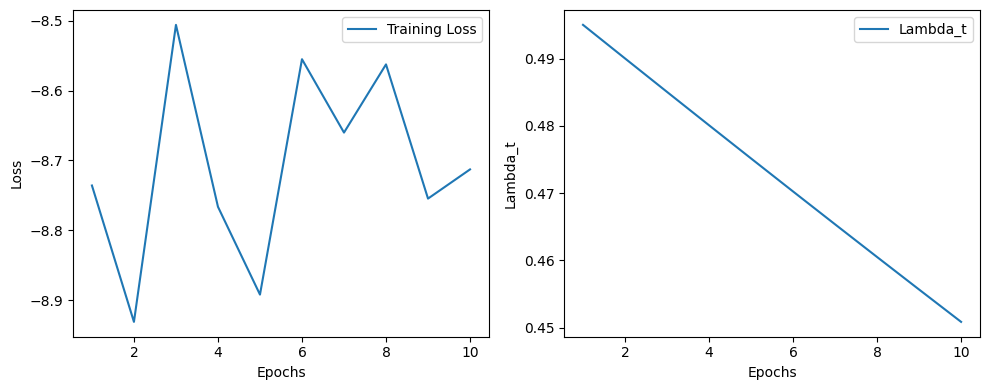

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

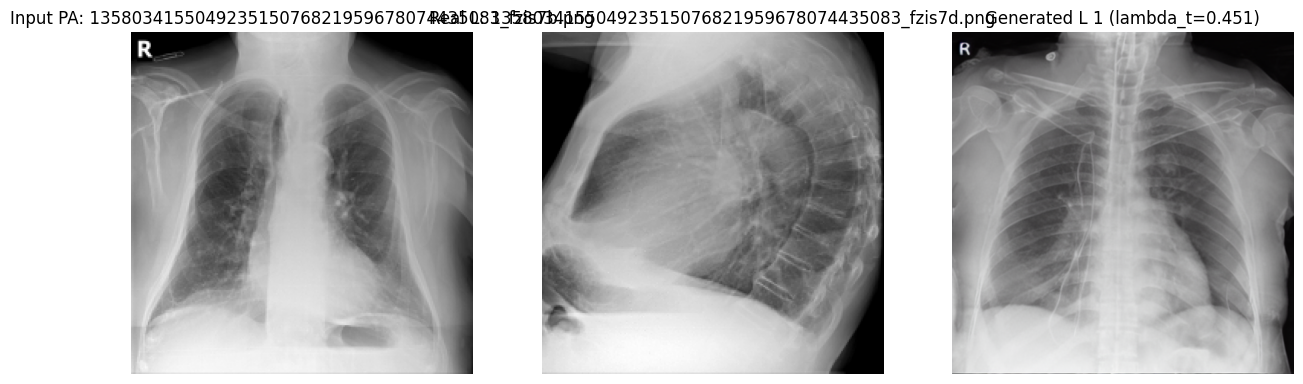

Lambda_t value for image 1: 0.451
Generated L view 1 saved to: /content/drive/MyDrive/GNN_project/generated_l_135803415504923515076821959678074435083_fzis7b.png_image_1.png
img_array type: <class 'numpy.ndarray'>, shape: (224, 224), dtype: uint8


  0%|          | 0/21 [00:00<?, ?it/s]

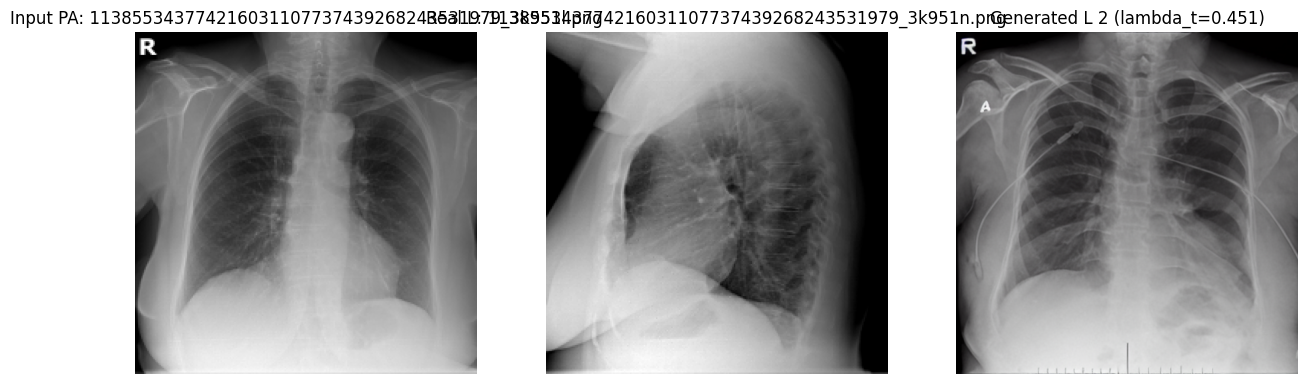

Lambda_t value for image 2: 0.451
Generated L view 2 saved to: /content/drive/MyDrive/GNN_project/generated_l_113855343774216031107737439268243531979_3k951l.png_image_2.png


In [5]:
if __name__ == "__main__":
    dataset = load_data(dataset_path)
    pairs = find_pairs(dataset)
    if not pairs:
        raise ValueError("No PA-L pairs found in dataset!")

    trained_lambda_t = train_lambda(pairs, T=1, epochs=10, lr=5e-4, batch_size=2)

    pipe = StableDiffusionImg2ImgPipeline.from_pretrained("Nihirc/Prompt2MedImage", torch_dtype=torch.float16).to(DEVICE)
    num_images_to_generate = min(2, len(pairs))
    for idx in range(num_images_to_generate):
        pa_sample, l_sample = pairs[idx]
        generated_l_img = generate_l_from_pa(pa_sample, trained_lambda_t, pipe)
        visualize_views(pa_sample, l_sample, generated_l_img, idx + 1)

        output_path = f"/content/drive/MyDrive/GNN_project/generated_l_{pa_sample[0]}_image_{idx + 1}.png"
        generated_l_img.save(output_path)
        print(f"Generated L view {idx + 1} saved to: {output_path}")